# A GARCH MODEL FOR PREDICTING APPLE STOCK PRICE RETURNS
By Teye Richard Gamah

### Inspiration: This model can help financial investors who are interested in investing in Apple Stock Market to be able to make good decisions based on the model's predeictions.

In [ ]:
# Import basic libraries for data gathering and wrangling 
import pandas as pd
import requests

### Data gathering

In [ ]:
def get_daily(ticker, output_size = "full"):

    """Get daily time series of an equity from AlphaVantage API.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the equity.
    output_size : str, optional
        Number of observations to retrieve. "compact" returns the
        latest 100 observations. "full" returns all observations for
        equity. By default "full".

    Returns
    -------
    pd.DataFrame
        Columns are 'open', 'high', 'low', 'close', and 'volume'.
        All are numeric.
    """
    # Create URL (8.1.5)
    url = (
        "https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?"
        "function=TIME_SERIES_DAILY&"
        f"symbol={ticker}&"
        f"outputsize={output_size}&"
        f"datatype=json&"
        f"apikey=..." # took the API Key off
    )

    # Send request to API (8.1.6)
    response = requests.get(url = url)

    # Extract JSON data from response (8.1.10)
    response_data = response.json()
    
    if "Time Series (Daily)" not in response_data.keys():
        raise Exception(
            f"Invalid API call. Check that ticker symbol '{ticker}' is correct"
        )
    # Read data into DataFrame (8.1.12 & 8.1.13)
    stock_data = response_data["Time Series (Daily)"]
    df = pd.DataFrame.from_dict(stock_data, orient = "index", dtype = float)

    # Convert index to `DatetimeIndex` named "date" (8.1.14)
    df.index = pd.to_datetime(df.index)
    df.index.name = "date"

    # Remove numbering from columns (8.1.15)
    df.columns = [c.split(". ")[1] for c in df.columns]

    # Return DataFrame
    return df

In [ ]:
# Test function
apple = get_daily(ticker="AAPL")

print(apple.info())
apple.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5814 entries, 2022-12-07 to 1999-11-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    5814 non-null   float64
 1   high    5814 non-null   float64
 2   low     5814 non-null   float64
 3   close   5814 non-null   float64
 4   volume  5814 non-null   float64
dtypes: float64(5)
memory usage: 272.5 KB
None


,open,high,low,close,volume
date,,,,,
2022-12-07,142.190,143.3700,140.00,140.94,69721094.0
2022-12-06,147.075,147.3000,141.92,142.91,64727186.0
2022-12-05,147.770,150.9199,145.77,146.63,68826442.0
2022-12-02,145.960,148.0000,145.65,147.81,65447446.0
2022-12-01,148.210,149.1300,146.61,148.31,71250416.0


### Data Wrangling

The date need to be sorted from earliest to present since the prediction is going to be based on time series analysis

In [ ]:
# Sort DataFrame ascending by date
apple.sort_index(ascending = True, inplace = True)
apple.head()



,open,high,low,close,volume
date,,,,,
1999-11-01,80.00,80.69,77.37,77.62,2487300.0
1999-11-02,78.00,81.69,77.31,80.25,3564600.0
1999-11-03,81.62,83.25,81.00,81.50,2932700.0
1999-11-04,82.06,85.37,80.62,83.62,3384700.0
1999-11-05,84.62,88.37,84.00,88.31,3721500.0


Since the analysis is going to be based on the **stock returns**, a `return` column need to be calculated based on the **percentage change** of the **closing stock market price**

In [ ]:
# Create "return" column
apple["return"] = apple["close"].pct_change() * 100

apple.head()

,open,high,low,close,volume,return
date,,,,,,
1999-11-01,80.00,80.69,77.37,77.62,2487300.0,NaN
1999-11-02,78.00,81.69,77.31,80.25,3564600.0,3.388302
1999-11-03,81.62,83.25,81.00,81.50,2932700.0,1.557632
1999-11-04,82.06,85.37,80.62,83.62,3384700.0,2.601227
1999-11-05,84.62,88.37,84.00,88.31,3721500.0,5.608706


The analysis is going to be based on only **stock returns**, therefore the other columns need to be dropped.

In [ ]:
# Dropping other columns
apple.drop(columns = ['open', 'high', 'low', 'volume', 'close'], inplace = True)

apple.head()

,return
date,
1999-11-01,NaN
1999-11-02,3.388302
1999-11-03,1.557632
1999-11-04,2.601227
1999-11-05,5.608706


Time series analysis usually deals with a **Series** dataset. Therefore, the **dataframe** need to be converted to a **Series** dataset

In [ ]:
# Converting dataframe to series
apple = apple.squeeze()

apple.head()

date
1999-11-01         NaN
1999-11-02    3.388302
1999-11-03    1.557632
1999-11-04    2.601227
1999-11-05    5.608706
Name: return, dtype: float64

There are **null values** in the dataset which need to be **dropped** since null values **can hurt the model** and time series data should not have a null value in it. 

In [ ]:
# Dropping null values
apple.drop(index=apple.index[0], 
        axis=0, 
        inplace=True)

apple.head()

date
1999-11-02    3.388302
1999-11-03    1.557632
1999-11-04    2.601227
1999-11-05    5.608706
1999-11-08    9.126939
Name: return, dtype: float64

## Exploratory Analysis and Model Building 

In [ ]:
# Importing necessary libraries for analysis and building of the model
import matplotlib.pyplot as plt
import numpy as np

from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Exploratory Analysis

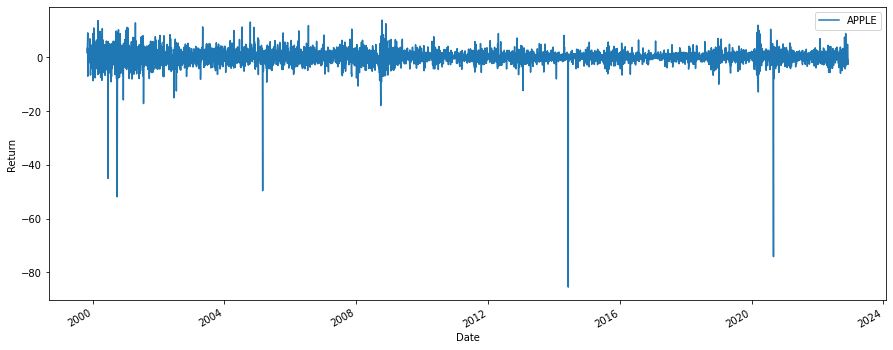

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for `apple`
apple.plot(ax=ax, label="APPLE")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

The line plot show that Apple's stock prices have highs and lows over the years

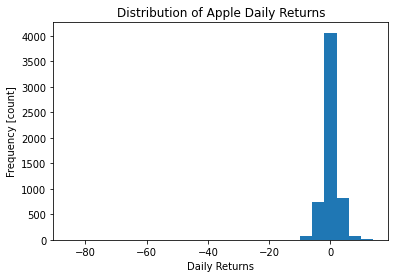

In [ ]:
# Create histogram of `apple`, 25 bins
plt.hist(apple, bins = 25)

# Add axis labels
plt.xlabel("Daily Returns")
plt.ylabel("Frequency [count]")


# Add title
plt.title("Distribution of Apple Daily Returns");

This histogram shows that the stock returns are highly concentrated around 0


We can determine the daily volatility (standard deviation) of the stock returns

In [ ]:
# Calculate Apple's Daily Volatility
apple_daily_volatility = apple.std()


print("Apple Daily Volatility:", apple_daily_volatility)


Apple Daily Volatility: 3.055773828213219


3.056 is pretty much okay for Apple's daily stock return

Let's considert the Annual Volatility 

This can be done by finding the **square root** of the number of trading days in a year which is **252** and multiplying it by the **daily volatility**. 

In [ ]:
# Calculate Apple's Annual Volatility
apple_annual_volatility = apple_daily_volatility * np.sqrt(252)

print("Apple Annual Volatility:", apple_annual_volatility)

Apple Annual Volatility: 48.50890567387193


48.51, annual volatility? Interesting!

Let's find a 50 days Rolling Volatility

In [ ]:
# Rolling 50 days volatility
apple_rolling_50d_volatility = apple.rolling(window = 50).std().dropna()

print("rolling_50d_volatility type:", type(apple_rolling_50d_volatility))
print("rolling_50d_volatility shape:", apple_rolling_50d_volatility.shape)
apple_rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (5764,)


date
2000-01-12    4.109816
2000-01-13    4.357600
2000-01-14    4.380742
2000-01-18    4.391107
2000-01-19    4.339636
Name: return, dtype: float64

Let's visualize the 50 Days Rolling Volatility with the returns to get more insights.

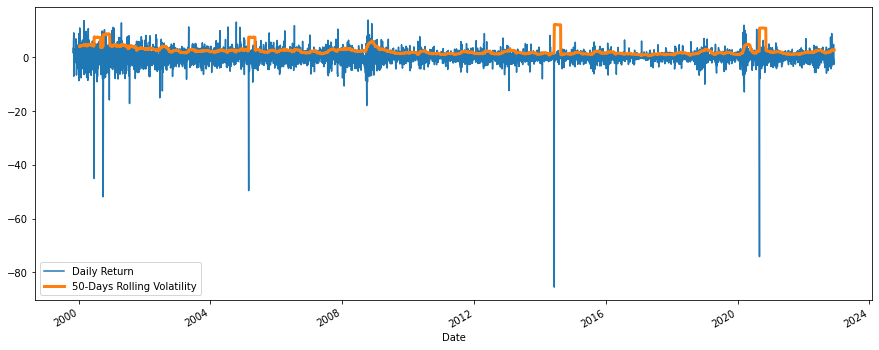

In [ ]:
# Plotting Apple's returns against 50 Days Rolling Volatility
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `apple`
apple.plot(ax = ax, label = "Daily Return")

# Plot `apple_rolling_50d_volatility`
apple_rolling_50d_volatility.plot(ax = ax, label = "50-Days Rolling Volatility", linewidth = 3)

# Add x-axis label
plt.xlabel("Date")

# Add legend
plt.legend();

Huh, this seems interesting, as the rolling volatility seems to follow the trends of the return. 

Since the some of the **return values** are **negative**, let's plot a time series for the **squared values** of the returns

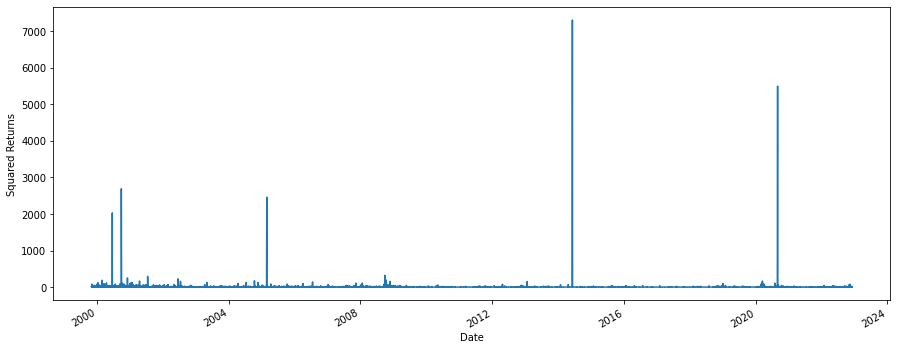

In [ ]:
# Time Series plot of Squared values of Apple's Returns
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(apple ** 2).plot(ax = ax)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Squared Returns");

This looks okay, but most of the values seem to be **within 0 to 1000**.

Let's investigate more by using the **square root** rather. 

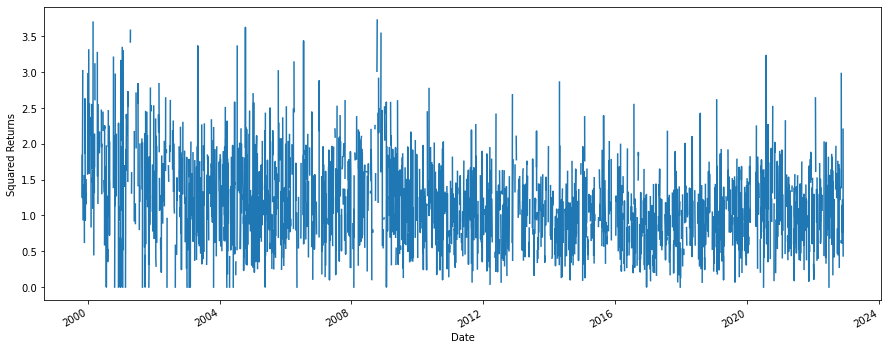

In [ ]:
# Time Series plot of Squared values of Apple's Returns
fig, ax = plt.subplots(figsize=(15, 6))

# Plot square root of returns
(apple ** 0.5).plot(ax = ax)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Squared Returns");

Mmm, this seems to be interesting time series plot.

Let's consider the **correlation** that exist in the `returns` using their **squared values**.

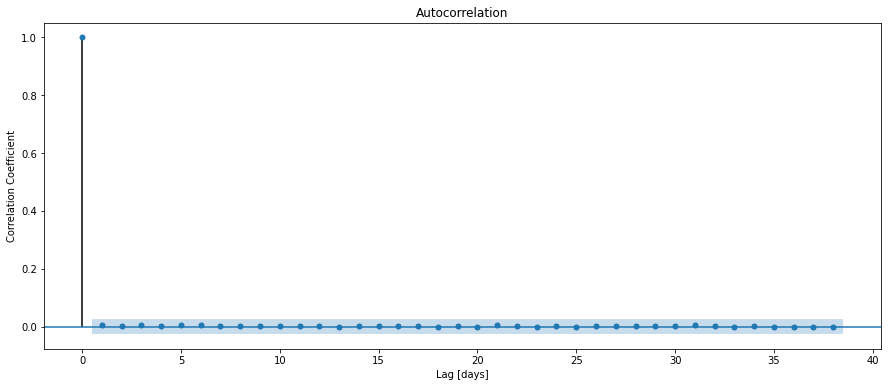

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(apple ** 2, ax = ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

It seems there is **no strong correlation** among the values.

Let's consider a **Partial Correlation**. 

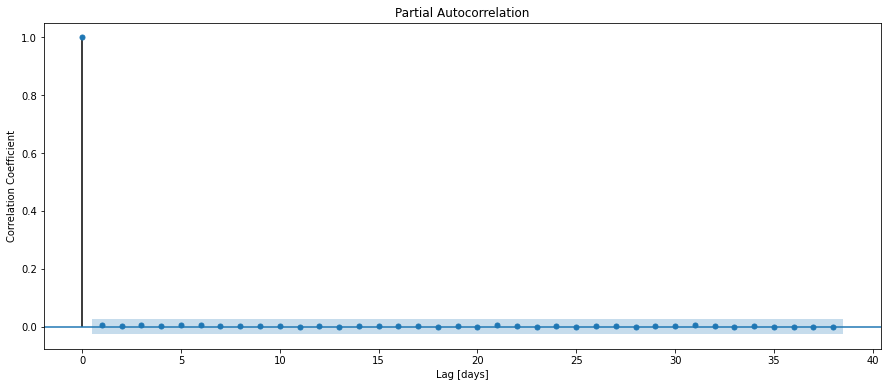

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(apple ** 2, ax = ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

The Partial Correlation also shows no much correlation. 

### Build Model

Let's train the model on 80% of the dataset

In [ ]:
cutoff_test = int(len(apple) * 0.8)
apple_train = apple.iloc[:cutoff_test]

print("apple_train type:", type(apple_train))
print("apple_train shape:", apple_train.shape)
apple_train.tail()

apple_train type: <class 'pandas.core.series.Series'>
apple_train shape: (4650,)


date
2018-04-20   -4.097222
2018-04-23   -0.289645
2018-04-24   -1.391915
2018-04-25    0.435743
2018-04-26    0.348304
Name: return, dtype: float64

#### Iterate

Build the **GARCH MODEL** using **ARCH(1,1)**

In [ ]:
# Build and train model
model = arch_model(
    apple,
    p = 1,
    q = 1,
    rescale = False
).fit(disp = 0)
print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14514.2
Distribution:                  Normal   AIC:                           29036.3
Method:            Maximum Likelihood   BIC:                           29063.0
                                        No. Observations:                 5813
Date:                Thu, Dec 08 2022   Df Residuals:                     5812
Time:                        17:50:03   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu         2.5433e-03  9.212e-02  2.761e-02      0.978 [ -0.178,  0.183]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.3697      0.437      0.846      0.398     [ -0.487,  1.226]
alpha[1]       0.0508  2.349e-02      2.162  3.063e-02 [4.742e-03,9.681e-02]
beta[1]        0.9230  3.411e-02     27.061 2.825e-161     [  0.856,  0.990]
============================================================================

Covariance estimator: robust
"""

The **AIC** and **BIC** values seem to be very good. The **omaga**, **alpha** and **beta** **P>|t|** values are less than **0.5** and therefore shows that the model would perform well. 

Time Series plot of Apple's Returns and Conditional Volatility for the model

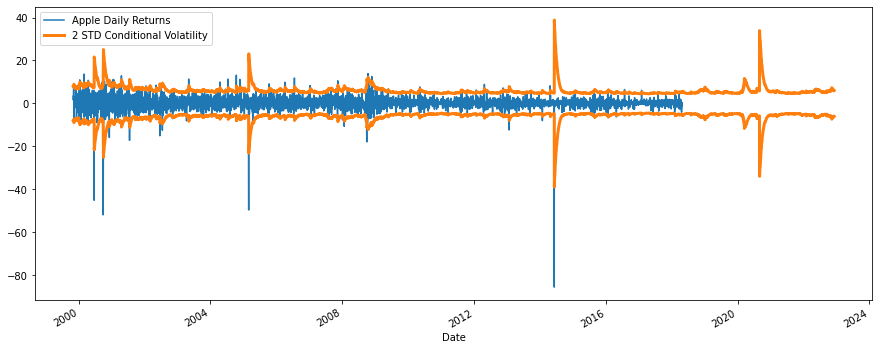

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `apple_train`
apple_train.plot(ax = ax, label = "Apple Daily Returns")

# Plot conditional volatility * 2
(2* model.conditional_volatility).plot(ax= ax, color = "C1", label = "2 STD Conditional Volatility", linewidth = 3)

# Plot conditional volatility * -2
(-2 * model.conditional_volatility).rename("").plot(ax= ax, color = "C1", linewidth = 3)

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

The model's time series plot seems to follow the trend of the return. This is good news. 

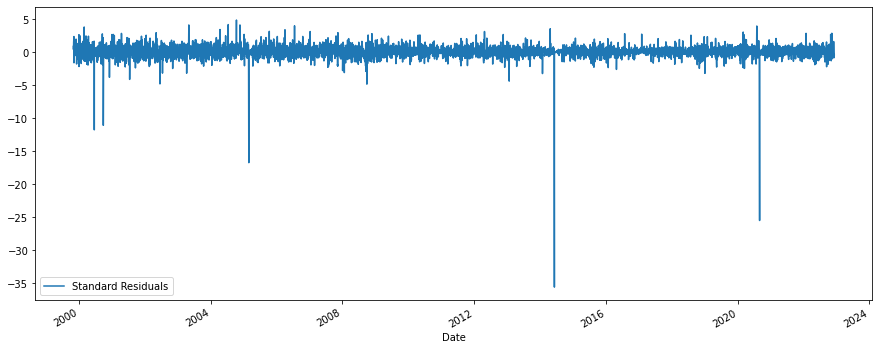

In [ ]:
#Create a time series plot of the standardized residuals for the model.

fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax =ax, label = "Standard Residuals")

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

The **Standard Residual** time series also follows the trend of the stock returns

Let's plot a **histogram** to get more insights.

Text(0.5, 1.0, 'Distribution of Standardized Residuals')

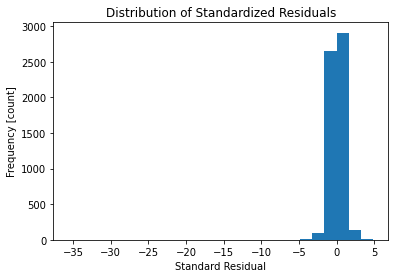

In [ ]:
# Create histogram of standardized residuals, 25 bins
plt.hist(model.std_resid, bins = 25)

# Add axis labels
plt.xlabel("Standard Residual")
plt.ylabel("Frequency [count]")

# Add title
plt.title("Distribution of Standardized Residuals")

The histogram seems to be in the same form as that of the stock returns

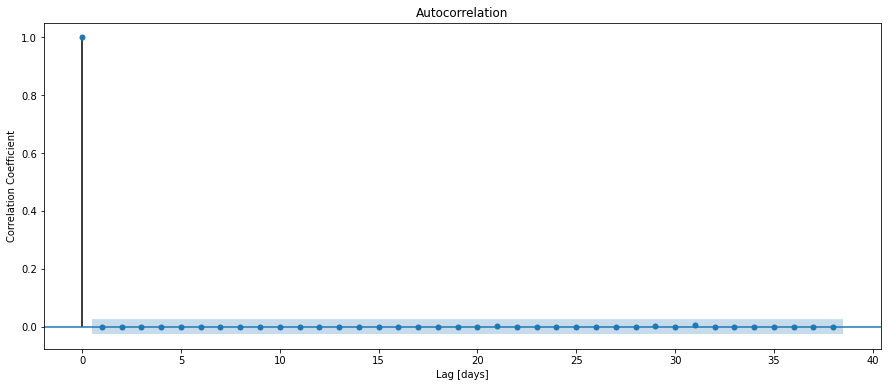

In [ ]:
#Create an ACF plot of the square of the standardized residuals

fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid ** 2, ax = ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");


The Autocorrelation plot of the Standard Residual also shows same as that of stock returns

#### Evaluate

Let's make a one day forecast using the model

In [ ]:
# Create a one-day forecast from the model
one_day_forecast = model.forecast(horizon = 1, reindex = False).variance

print("one_day_forecast type:", type(one_day_forecast))
one_day_forecast

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>


,h.1
date,
2022-12-07,8.79269


The forecast here is the variance. We need the standard deviation (volatility) of the return values 

In [ ]:
# Forecast for current date plus 1 horizon day
np.sqrt(one_day_forecast.iloc[0, 0])

2.9652470359221925

#### Walk Forward Validation

Let's create a Walk Forward validation of the model

In [ ]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(apple) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = apple.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train, p = 1, q = 1, rescale = False).fit(disp = 0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon = 1, reindex = False).variance.iloc[0, 0] ** 0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=apple.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (1162,)


date
2018-04-30    2.635000
2018-05-01    2.656225
2018-05-02    2.718381
2018-05-03    3.055032
2018-05-04    2.906778
dtype: float64

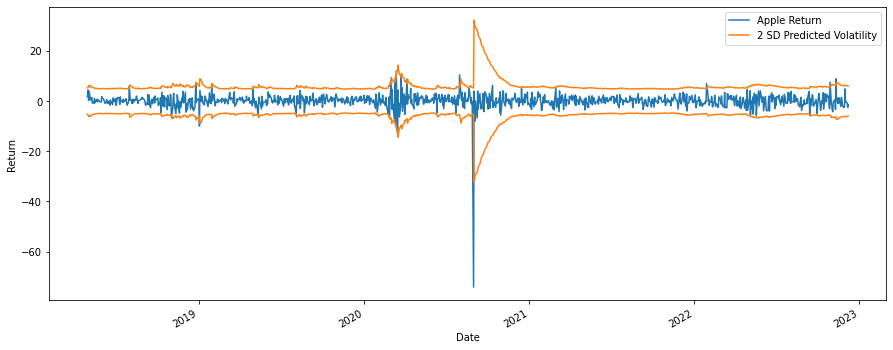

In [ ]:
# Visualize the model's test predictions.
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
apple.tail(test_size).plot(ax=ax, label="Apple Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).rename("").plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

The model seems to be predicting right as it follows the stock return series. 

## Communicate Result

In [ ]:
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
print(prediction)

# Calculate forecast start date
start = prediction.index[0] + pd.DateOffset(days = 1)

# Create date range
prediction_dates = pd.bdate_range(start = start, periods = prediction.shape[1])

# Create prediction index labels, ISO 8601 format
prediction_index = [d.isoformat() for d in prediction_dates]

print("prediction_index type:", type(prediction_index))
print("prediction_index len:", len(prediction_index))
prediction_index[:3]

                 h.1       h.2       h.3       h.4      h.5
date                                                       
2022-12-06  3.003706  3.025783  3.047128  3.067771  3.08774
prediction_index type: <class 'list'>
prediction_index len: 5


['2022-12-07T00:00:00', '2022-12-08T00:00:00', '2022-12-09T00:00:00']

Create a `clean_prediction` function. It should take a variance prediction DataFrame as input and return a dictionary where each key is a date in ISO 8601 format and each value is the predicted volatility.

In [ ]:
def clean_prediction(prediction):

    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start = prediction.index[0] + pd.DateOffset(days = 1)

    # Create date range
    prediction_dates = pd.bdate_range(start = start, periods = prediction.shape[1])

    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]


    # Extract predictions from DataFrame, get square root
    data = prediction.values.flatten() ** 0.5

    # Combine `data` and `prediction_index` into Series
    prediction_formatted = pd.Series(data, index = prediction_index)

    # Return Series as dictionary
    return prediction_formatted.to_dict()

In [ ]:
# Testing function

prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)

prediction_formatted

{'2022-12-07T00:00:00': 3.0037058178821496,
 '2022-12-08T00:00:00': 3.0257831507916415,
 '2022-12-09T00:00:00': 3.047128087521332,
 '2022-12-12T00:00:00': 3.0677708215765116,
 '2022-12-13T00:00:00': 3.08773985776271,
 '2022-12-14T00:00:00': 3.107062141585393,
 '2022-12-15T00:00:00': 3.1257631758271374,
 '2022-12-16T00:00:00': 3.1438671258467514,
 '2022-12-19T00:00:00': 3.16139691492802,
 '2022-12-20T00:00:00': 3.178374310823448}

## Reference
WorldQuant Data Science Lab at https://www.wqu.edu/programs/applied-ds-lab/
